In [1]:
#%matplotlib widget

from lib.hamiltonian import H_B, H_D, H_P
from lib.time import S
from lib import X, D
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from joblib import Memory
import itertools
import tqdm

memory = Memory(location=".joblib_cache", verbose=0)

N = 4
nsteps = 600
T_0 = 15
T_f = 950
pen = 10
beta = -1

Hf = H_B(N) + pen * H_P(N)
Hi = beta*H_D(N, X)

psi_f = np.diag(Hf)

P = np.array([1/2, 1/np.sqrt(2), 1/2], dtype="complex")
initialState = P.copy()
for _ in range(N-1):
    initialState = np.kron(initialState, P)

ts = np.linspace(T_0, T_f, nsteps)
f_all = False

After we have imported all of our dependencies, we can go ahead and implement the Time-dependent Schrodinger equation which was proposed by Yves Rezus.



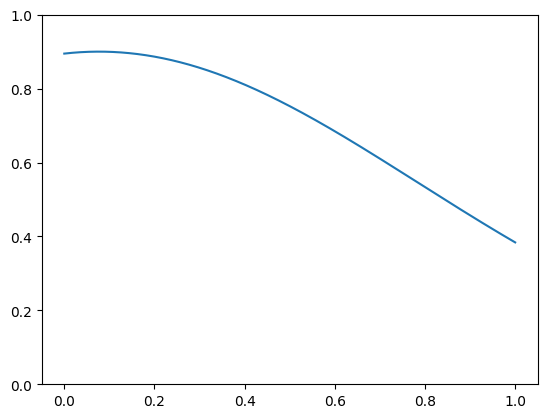

In [2]:
x = np.linspace(0, 1, 1000)
smax = 0.9
def St(x):
    # return smax*np.exp(-(x-D/2)**4/5000)
    return smax * np.exp(-(x - D/13)**2)

y = S(x)

plt.ylim([0, 1])
plt.plot(x, y)
plt.show()

To first understand how the energies change in this new scheme we should look at how the hamiltonian changes as we tune $ \gamma $ from 0 -> 1. 

$$
 H = \gamma*H_f + (1 - \gamma)*H_i
$$

In [3]:
def hamiltonian_energies(N):
    energies = []
    gamma_vals = []
    vecs = []
    
    for t in ts:
        gamma = t/T_f
        H = gamma * Hf + (1 - gamma) * Hi
        eigvals, vec = np.linalg.eigh(H)
        energies.append(eigvals)
        vecs.append(vec)
        gamma_vals.append(gamma)

    return np.array(energies), np.array(vecs), gamma_vals

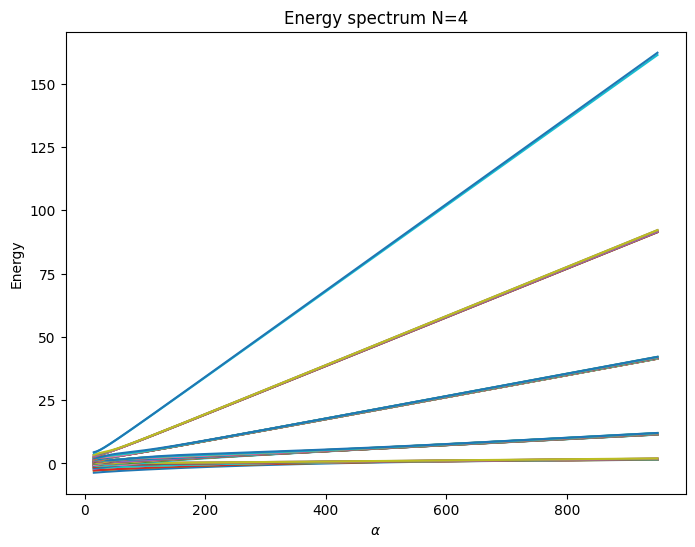

In [4]:
energies, vecs, gamma_vals = hamiltonian_energies(N)

plt.figure(figsize=(8, 6))
for i in range(energies.shape[1]):
    plt.plot(ts, energies[:, i])
plt.xlabel(r"$\alpha$")
plt.ylabel("Energy")
plt.title(f"Energy spectrum {N=}")
plt.savefig("spectrum.pdf")
plt.show()

We can no see how the energy spectrum looks 

(-1, -1, 1, 1)


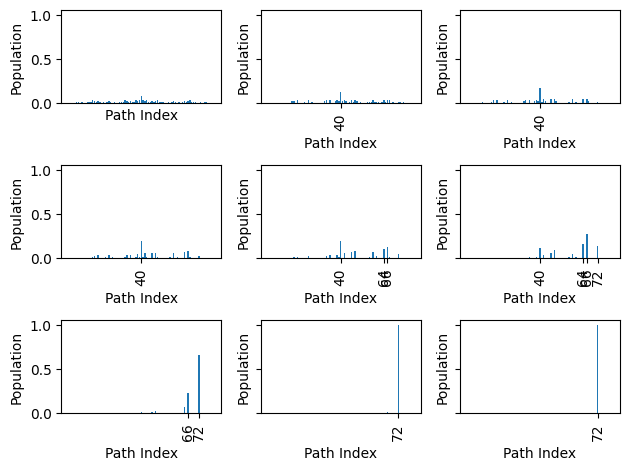

In [5]:
@memory.cache
def all_move_sequences(N):
    moves = (1, 0, -1)
    return list(itertools.product(moves, repeat=N))

vec = np.array([np.abs(v[:, 0])**2 for v in vecs])
fig, axes = plt.subplots(3, 3, sharey=True)
indices = np.arange(vecs.shape[1])
alpha_indices = np.linspace(0, len(vec)-1, 9, dtype=int)
selected_eigvecs = [vec[i] for i in alpha_indices]
moves = all_move_sequences(N)
for i, eigvec in enumerate(selected_eigvecs):
    ax = axes.flat[i]
    ax.bar(indices, eigvec, linewidth=1)
    ax_ids = []
    for j in range(len(eigvec)):
        if eigvec[j] > 1e-1:
            ax_ids.append(j)
    ax.set_xlabel("Path Index")
    ax.set_ylabel("Population")
    ax.set_xticks(ax_ids)
    ax.set_xticklabels(ax_ids, rotation=90)
last = selected_eigvecs[-1]
ind = np.argwhere(last > 1e-2)
for i in ind:
    print(moves[i[0]])

plt.tight_layout() 
plt.show()

In the plot above we can see which state we should end up in. 

This means that we only need to compute the following four matrix exponentials 
$$
\begin{eqnarray}
e^{A_0} & = & \exp\left[-i\gamma_0 H_f \frac{\Delta t^2}{4\hbar}\right]  \\
M_A & = & \exp\left[-i\gamma_0 H_f \frac{\Delta t^2}{2\hbar}\right]  \\
e^{B_0} & = & \exp \left[ -i H_i \frac{\Delta t}{\hbar} + 
i \gamma_0 H_i\frac{\Delta t^2}{2\hbar} \right]\\
M_B & = & \exp\left[i\gamma_0 H_i \frac{\Delta t^2}{\hbar}\right]
\end{eqnarray}
$$

In [6]:
@memory.cache
def yves_TDSE(psi_init, Hi, Hf, T, steps=10000):
    dt = T / steps
    # psi = 1/np.sqrt(3**N)*np.ones(3**N, dtype='complex')
    psi = psi_init.copy()

    eB = sp.linalg.expm(-1j * ( 1 - dt / (2*T)) * Hi * dt)
    MB = sp.linalg.expm(1j * Hi * dt**2/T)
    t = 0
    steps = 0
    while t < T:
        eA = sp.linalg.expm(-1j*(t + dt / 2)*dt/(2*T)*Hf)
        
        psi = eA @ eB @ eA @ psi

        # update eA and eB for next step using the recursion
        eB = MB @ eB

        t += dt
        steps += 1

    # final normalization & sanity
    return psi



In [ ]:
from concurrent.futures import ProcessPoolExecutor

# --- Your function ---
def compute_fidelity(t):
    psi = yves_TDSE(initialState, Hi, Hf, t)
    fidelity = np.abs(psi[gs_idx])**2
    return fidelity

# --- Precomputation ---
gs_idx = np.argmin(psi_f)

# --- Parallel loop ---
with ProcessPoolExecutor() as pool:
    fidelities = list(tqdm.tqdm(pool.map(compute_fidelity, ts), total=len(ts)))

"""
fidelities = []
gs_idx = np.argmin(psi_f)
for t in tqdm.tqdm(ts):
    psi = yves_TDSE(initialState, Hi, Hf, t)
    fidelity = np.abs(psi[gs_idx])**2
    fidelities.append(fidelity)
"""

plt.figure()
#plt.ylim(0, 1)
plt.xlabel("Tf")
plt.ylabel(r"$ |<\psi^\dagger_{gs} | \psi(t=T_f)>|^2 $")
plt.plot(ts, fidelities)
plt.savefig(f"{N=}-different_Tf.pdf")
plt.show()

  0%|                                                                                                                                                                                                           | 0/600 [00:00<?, ?it/s]

In [ ]:
import csv
fidelities = np.array(fidelities)
with open("fids3.csv", "a") as f:
    writer = csv.writer(f)
    
    writer.writerow([N, fidelities.tolist()])